# Experimentación cualitativa

## Compilado

In [ ]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

## Imports

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as py
import time
import tqdm
from sklearn.model_selection import KFold

from plotly import tools
from plotly.offline import iplot

# Remoción de outliers
from scipy import stats

# AUXILIARES
from funcionesAux import *

In [2]:
import metnum

## Datos

In [3]:
data = pd.read_csv('../data/train.csv')

## Idea

1. Aplicar posibles segmentaciones
    1. Por tipo de propiedad (depto/casa)
    2. Por escala de valor del precio
    3. Por tipo de uso de la propiedad (comercial/urbano/industrial)
    4. Por provincia/ciudad
2. Feature engineering
3. Predecir otra variable

En todos los casos, realizar _cross validation_ con un $K=10$

## Matriz de Correlación

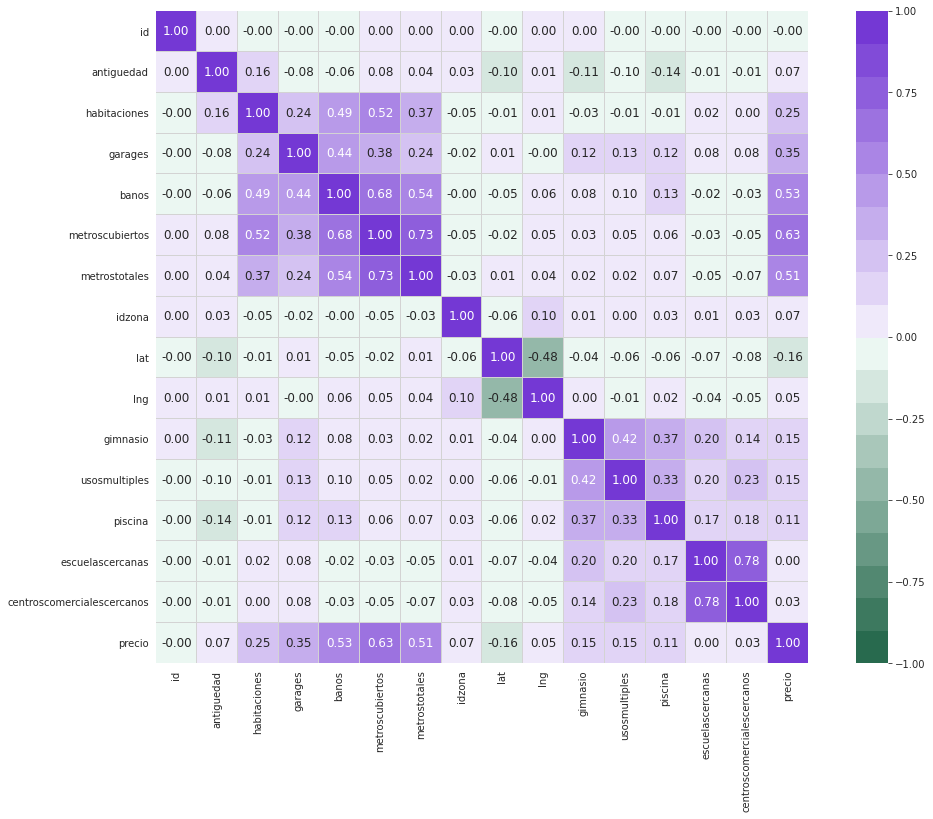

In [4]:
corr = corrHeatmap(data)["metroscubiertos"].sort_values(ascending=False)

## Funciones para predicciones

In [5]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
import statsmodels.formula.api as smf

def linearReg(df, features, prediction):
    dfFeat = df[features]

    y = df[prediction].values
    y = y.reshape(len(y),1)
    x = dfFeat.values
    x = x.reshape(len(x),len(features))
    
    linear_regressor = metnum.LinearRegression()
    linear_regressor.fit(x,y)
    predictions = linear_regressor.predict(x)
    
    return predictions


def getErrors(predictions, observed):
    error = metnum.LossFunctions()

    print("MSE   : %f" % (error.meanSquareError(observed, predictions)))
    print("MAE   : %f" % (error.meanAbsoluteError(observed, predictions)))
    print("RMSE  : %f" % (error.rootMeanSquareError(observed, predictions)))
    print("RMSLE : %f" % (error.rootMeanSquareLogError(observed, predictions)))

    #print("Elías no puede correr metnum")

    return

def linearRegressionTest(train, test, features, target):
    dfFeat = train[features]
    dfTestFeat = test[features]

    y = train[target].values
    yTrain = y.reshape(len(y),1)
    x = dfFeat.values
    xTrain = x.reshape(len(x),len(features))
    
    #y = test[target].values
    #observed = y.reshape(len(y),1)
    x = dfTestFeat.values
    xTest = x.reshape(len(x),len(features))
    
    linear_regressor = metnum.LinearRegression()
    linear_regressor.fit(xTrain,yTrain)
    predictions = linear_regressor.predict(xTest)
    
    
    test['prediction'] = predictions
    test = test[test["prediction"] >= 0]
    
    observed = test[target].values
    observed = observed.reshape(len(observed),1)
    
    predictions = test['prediction'].values
    predictions = predictions.reshape(len(predictions),1)
    
    error = metnum.LossFunctions()
    mse = error.meanSquareError(observed, predictions)
    mae = error.meanAbsoluteError(observed, predictions)
    rmse = error.rootMeanSquareError(observed, predictions)
    rmsle = error.rootMeanSquareLogError(observed, predictions)
    
    metrics = {'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'RMSLE': rmsle}
    
    return metrics

def linearRegression(train, test, features, target):
    dfFeat = train[features]
    dfTestFeat = test[features]

    y = train[target].values
    yTrain = y.reshape(len(y),1)
    x = dfFeat.values
    xTrain = x.reshape(len(x),len(features))
    
    x = dfTestFeat.values
    xTest = x.reshape(len(x),len(features))
    
    linear_regressor = metnum.LinearRegression()
    linear_regressor.fit(xTrain,yTrain)
    predictions = linear_regressor.predict(xTest)
    
    
    test['prediction'] = predictions
    test = test[test["prediction"] >= 0]
    
    observed = test[target].values
    observed = observed.reshape(len(observed),1)
    
    predictions = test['prediction'].values
    predictions = predictions.reshape(len(predictions),1)
    
    error = metnum.LossFunctions()
    mse = error.meanSquareError(observed, predictions)
    mae = error.meanAbsoluteError(observed, predictions)
    rmse = error.rootMeanSquareError(observed, predictions)
    rmsle = error.rootMeanSquareLogError(observed, predictions)
    
    metrics = {'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'RMSLE': rmsle}
    
    return metrics, predictions, test

def linearRegressionPCR(train, test, features, target, alpha):
        
    dfFeat = train[features]
    dfTestFeat = test[features]

    y = train[target].values
    yTrain = y.reshape(len(y),1)
    x = dfFeat.values
    xTrain = x.reshape(len(x),len(features))
    x = dfTestFeat.values
    xTest = x.reshape(len(x),len(features))
    
    pca = metnum.PCA(alpha)
    pca.fit(xTrain)
    xTrain = pca.transform(xTrain)
    xTest = pca.transform(xTest)
    
    linear_regressor = metnum.LinearRegression()
    linear_regressor.fit(xTrain,yTrain)
    predictions = linear_regressor.predict(xTest)
    
    test['prediction'] = predictions
    test = test[test["prediction"] >= 0]
    
    observed = test[target].values
    observed = observed.reshape(len(observed),1)
    
    predictions = test['prediction'].values
    predictions = predictions.reshape(len(predictions),1)
    
    error = metnum.LossFunctions()
    mse = error.meanSquareError(observed, predictions)
    mae = error.meanAbsoluteError(observed, predictions)
    rmse = error.rootMeanSquareError(observed, predictions)
    rmsle = error.rootMeanSquareLogError(observed, predictions)
    
    metrics = {'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'RMSLE': rmsle, 'Features': alpha, 'Categoria': 'PCR'}
    
    return metrics

In [6]:
def forwardSelection(df, target): 
    # Selecciono la variable más correlacionada con prediction
    features = []
    mostCorrelatedVar = mostCorrelated(df, target)
    features.append(mostCorrelatedVar)
    
    eps = 0.001
    modelR2 = 0

    # Busco los features
    variables = list(df.columns)
    variables.remove(features[0])
    variables.remove(target[0])
            
    while(len(variables) > 0):
        nextFeature = {}
        kf = KFold(n_splits = 4)
        
        for trainidx, testidx in kf.split(df):
            maxR2 = 0
            maxVar = 0
        
            train = df[:trainidx[-1]]
            test = df[testidx[0]:testidx[-1]]
            
            for var in variables:
                categorias = features + [var]   
                metricas, predictions, test = linearRegression(train, test, categorias, target)
                modelo = getModel(categorias, target)
                actualR2, aic = getModelStatistics(predictions, test, target, modelo)

                if maxR2 < actualR2:
                    maxVar = var
                    maxR2  = actualR2
            
            if maxVar in nextFeature:
                nextFeature[maxVar].append(maxR2)
            else:
                nextFeature[maxVar] = [maxR2]
                
        maxVar, maxR2 = masFrecuente(nextFeature)
        if abs(modelR2 - maxR2) < eps or maxR2 < modelR2:
            break
        
        modelR2 = maxR2
        features.append(maxVar)
        variables.remove(maxVar)
    
    print("R2: %f" %(modelR2))
    
    #predictions = linearReg(df, features, target)

    #dfPred = df.copy()
    #dfPred['prediction'] = predictions
    #dfPred = dfPred[dfPred["prediction"] >= 0]
    
    #observed = dfPred[target].values
    #observed = observed.reshape(len(observed),1)
    
    #predictions = dfPred['prediction'].values
    #predictions = predictions.reshape(len(predictions),1)
    
    #getErrors(predictions, observed)

    return features

def forwardSelectionAIC(df, target):    
    # Selecciono la variable más correlacionada con prediction
    features = []
    mostCorrelatedVar = mostCorrelated(df, target)
    features.append(mostCorrelatedVar)
    
    predictions = linearReg(df, features, target)
    modelo = getModel(features, target)
    r2, modelAIC = getModelStatistics(predictions, df, target, modelo)
    eps = modelAIC * 0.0001
    
    # Busco los features
    variables = list(df.columns)
    variables.remove(features[0])
    variables.remove(target[0])
        
    while(len(variables) > 0):
        minVar = variables[0]
        categorias = features + [minVar]
        
        predictions = linearReg(df, categorias, target)
        modelo = getModel(categorias, target)
        r2, minAIC = getModelStatistics(predictions, df, target, modelo)
        
        for var in variables[1:]:
            categorias = features + [var]
            
            predictions = linearReg(df, categorias, target)
            modelo = getModel(categorias, target)
            r2, actualAIC = getModelStatistics(predictions, df, target, modelo)            
            
            if actualAIC < minAIC:
                minVar = var
                minAIC  = actualAIC
        
        if abs(modelAIC - minAIC) < eps or modelAIC < minAIC:
            break
        
        modelAIC = minAIC
        features.append(minVar)
        variables.remove(minVar)
    
    print("AIC: %f" %(modelAIC))
    predictions = linearReg(df, features, target)
    
    dfPred = df.copy()
    dfPred['prediction'] = predictions
    dfPred = dfPred[dfPred["prediction"] >= 0]
    
    observed = dfPred[target].values
    observed = observed.reshape(len(observed),1)
    
    predictions = dfPred['prediction'].values
    predictions = predictions.reshape(len(predictions),1)
    
    getErrors(predictions, observed)
    
    return features

## Predicciones de metroscubiertos

In [19]:
data = pd.read_csv('../data/train.csv')
df = featureEng(data)

In [8]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
features = df.select_dtypes(include=numerics).columns.drop(["id", "metroscubiertos"]).to_list()
target   = ["metroscubiertos"]

dfs = {}
dfs = segmentaciones(df)

for segmentacion, dataframe in dfs.items():
    dataframe = dataframe.dropna()    
    dataframe = removeOutliers(dataframe, features, target)
    dataframe = dataframe.loc[:, (dataframe != 0).any(axis=0)]
    dfs[segmentacion] = dataframe

In [9]:
modelosR2 = {}
for segmentacion, dataframe in dfs.items():
    print("Generando el modelo para %s" %(segmentacion))  
    modelo = forwardSelection(dataframe, target)
    imprimir = "%s ~ %s" %(target[0], modelo[0])
    for feature in modelo[1:]:
        imprimir += " + %s" %(feature)
    print(imprimir)
    
    modelosR2[segmentacion] = modelo
    
    print("\n===================================================================================================\n")

Generando el modelo para urbano
R2: 0.727763
metroscubiertos ~ metrostotales + banos + precio + habitaciones + lng


Generando el modelo para comercial
R2: 0.392488
metroscubiertos ~ metrostotales + precio


Generando el modelo para casa
R2: 0.727134
metroscubiertos ~ precio + habitaciones + metrostotales + banos + lng + lat


Generando el modelo para depto
R2: 0.885005
metroscubiertos ~ metrostotales + banos + habitaciones


Generando el modelo para bajos
R2: 0.710641
metroscubiertos ~ metrostotales + banos + precio + habitaciones + lng


Generando el modelo para medios
R2: 0.597197
metroscubiertos ~ metrostotales + habitaciones + banos + antiguedad + gimnasio + idzona + indice_seguridad + garages


Generando el modelo para altos
R2: 0.597070
metroscubiertos ~ metrostotales + habitaciones + garages + gimnasio + banos




\begin{tabular}{rrrrl}
\toprule
          MSE &        MAE &        RMSE &     RMSLE & Segmentacion \\
\midrule
  1749.165531 &  29.984316 &   41.820675 &  0.264069 &       urbano \\
 10814.673383 &  78.667622 &  101.903585 &  0.456862 &    comercial \\
  1890.566812 &  31.425928 &   43.478014 &  0.256748 &         casa \\
   265.886907 &   7.888243 &   16.274403 &  0.137210 &        depto \\
  1518.333304 &  28.079539 &   38.963575 &  0.262150 &        bajos \\
  3091.867969 &  43.463473 &   55.597876 &  0.234073 &       medios \\
  2363.244519 &  38.087302 &   48.495850 &  0.187599 &        altos \\
\bottomrule
\end{tabular}



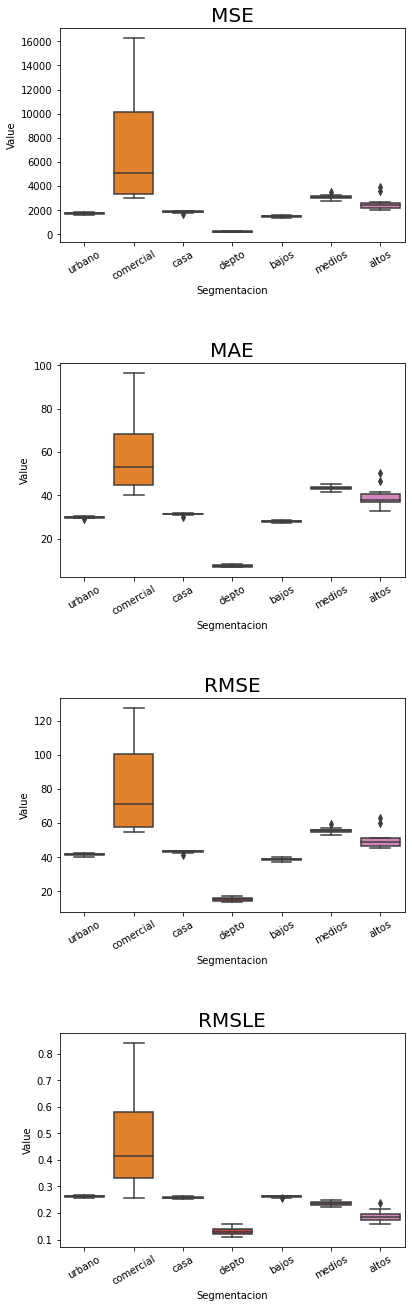

In [37]:
metricas = ['MSE', 'MAE', 'RMSE', 'RMSLE']
dfMSE = pd.DataFrame(columns = ['Segmentacion', 'Value'])
dfMAE = pd.DataFrame(columns = ['Segmentacion', 'Value'])
dfRMSE = pd.DataFrame(columns = ['Segmentacion', 'Value'])
dfRMSLE = pd.DataFrame(columns = ['Segmentacion', 'Value'])
allMetrics = pd.DataFrame(columns = metricas+['Segmentacion'])
#Ahora vemos las métricas que nos hayan dado para cada predicción. Podemos hacer un boxplot.
for segmentacion, dataframe in dfs.items():
    kf = KFold(n_splits = 10)
    segMetrics = pd.DataFrame(columns = metricas+['Segmentacion'])

    for trainidx, testidx in kf.split(dataframe):
        features = modelosR2[segmentacion]        
        train = dataframe[:trainidx[-1]]
        test = dataframe[testidx[0]:testidx[-1]]
        
        newMetricas = linearRegressionTest(train, test, features, ['metroscubiertos'])
        dfMSE = dfMSE.append({'Value': newMetricas['MSE'], 'Segmentacion': segmentacion} ,ignore_index = True)
        dfMAE = dfMAE.append({'Value': newMetricas['MAE'], 'Segmentacion': segmentacion} ,ignore_index = True)
        dfRMSE = dfRMSE.append({'Value': newMetricas['RMSE'], 'Segmentacion': segmentacion} ,ignore_index = True)
        dfRMSLE = dfRMSLE.append({'Value': newMetricas['RMSLE'], 'Segmentacion': segmentacion} ,ignore_index = True)
        
        newMetricas['Segmentacion'] = segmentacion
        segMetrics = segMetrics.append(newMetricas, ignore_index = True)
        segMetrics = segMetrics.groupby(['Segmentacion']).mean().reset_index()

    allMetrics = pd.concat([allMetrics, segMetrics])
    
print(allMetrics.to_latex(index=False))

fig, axs = plt.subplots(nrows = 4, figsize = (8,20))
fig.tight_layout(pad = 10.0)

bplot1 = sns.boxplot(data = dfMSE, x='Segmentacion', y='Value', ax = axs[0])
bplot1.set_title("MSE", size = 20)
bplot1.set_xticklabels(bplot1.get_xticklabels(), rotation=30)

bplot2 = sns.boxplot(data = dfMAE, x='Segmentacion', y='Value', ax = axs[1])
bplot2.set_xticklabels(bplot1.get_xticklabels(), rotation=30)
bplot2.set_title("MAE", size = 20)

bplot3 = sns.boxplot(data = dfRMSE, x='Segmentacion', y='Value', ax = axs[2])
bplot3.set_xticklabels(bplot1.get_xticklabels(), rotation=30)
bplot3.set_title("RMSE", size = 20)


bplot4 = sns.boxplot(data = dfRMSLE, x='Segmentacion', y='Value', ax = axs[3])
bplot4.set_xticklabels(bplot1.get_xticklabels(), rotation=30)
bplot4.set_title("RMSLE", size = 20)
figb = bplot4.get_figure()
figb.savefig("RMSLE.png")

## Segmentación por Provincias

In [20]:
df["provincia"].value_counts()

dfProv = df[df['provincia'].map(df['provincia'].value_counts()) > 5000]
dfProv["provincia"].value_counts()

dfCiudad = dfProv[dfProv['ciudad'].map(dfProv['ciudad'].value_counts()) > 3200]
dfCiudad["ciudad"].value_counts()

#dfCiudad[dfCiudad["ciudad"]== "Benito Juárez"]["tipodepropiedad"].value_counts()

Querétaro               12646
Benito Juárez           11013
Zapopan                 10360
San Luis Potosí          7925
Mérida                   7162
Monterrey                6946
Alvaro Obregón           6632
Naucalpan de Juárez      6554
Cuauhtémoc               6539
Miguel Hidalgo           5795
Atizapán de Zaragoza     5783
Tlalpan                  5721
Huixquilucan             5718
Coyoacán                 5293
Puebla                   4636
Guadalajara              4006
San Andrés Cholula       3805
Cuernavaca               3775
Tlalnepantla de Baz      3588
Cuautitlán Izcalli       3408
Tlajomulco de Zúñiga     3254
Name: ciudad, dtype: int64

In [21]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
features = df.select_dtypes(include=numerics).columns.drop(["id", "metroscubiertos"]).to_list()
target   = ["metroscubiertos"]

provincias = dfCiudad["provincia"].unique()
ciudades = dfCiudad["ciudad"].unique()

dfsProv = {}
dfsCiudad = {}

for provincia in provincias:
    dataframe = dfCiudad[dfCiudad["provincia"] == provincia]
    dataframe = dataframe.dropna()    
    dataframe = removeOutliers(dataframe, features, target)
    dataframe = dataframe.loc[:, (dataframe != 0).any(axis=0)]
    dfsProv[provincia] = dataframe
    
for ciudad in ciudades:
    dataframe = dfCiudad[dfCiudad["ciudad"] == ciudad]
    dataframe = dataframe.dropna()    
    dataframe = removeOutliers(dataframe, features, target)
    dataframe = dataframe.loc[:, (dataframe != 0).any(axis=0)]
    dfsCiudad[ciudad] = dataframe

In [22]:
modelosProv = {}
target = ['metroscubiertos']
for provincia, dataframe in dfsProv.items():
    print("Generando el modelo para %s" %(provincia))  
    modelo = forwardSelection(dataframe, target)
    imprimir = "%s ~ %s" %(target[0], modelo[0])
    for feature in modelo[1:]:
        imprimir += " + %s" %(feature)
    print(imprimir)
    
    modelosProv[provincia] = modelo
    
    print("\n===================================================================================================\n")
    

Generando el modelo para Distrito Federal
R2: 0.742525
metroscubiertos ~ metrostotales + banos + infracciones + precio + habitaciones + lat + antiguedad + lng + garages + seguridad + idzona


Generando el modelo para Jalisco
R2: 0.780176
metroscubiertos ~ metrostotales + banos + precio + habitaciones + lng + antiguedad + terraza


Generando el modelo para San luis Potosí
R2: 0.816774
metroscubiertos ~ precio + habitaciones + metrostotales + banos + indice_seguridad + antiguedad + lng


Generando el modelo para Querétaro
R2: 0.829983
metroscubiertos ~ precio + habitaciones + infracciones + metrostotales


Generando el modelo para Edo. de México
R2: 0.723731
metroscubiertos ~ precio + habitaciones + metrostotales + banos + lat + infracciones


Generando el modelo para Nuevo León
R2: 0.699397
metroscubiertos ~ precio + habitaciones


Generando el modelo para Puebla
R2: 0.772816
metroscubiertos ~ precio + metrostotales + habitaciones


Generando el modelo para Yucatán
R2: 0.812172
metroscu

In [23]:
modelosCiudad = {}
target = ['metroscubiertos']
for ciudad, dataframe in dfsCiudad.items():
    print("Generando el modelo para %s" %(ciudad))  
    modelo = forwardSelection(dataframe, target)
    imprimir = "%s ~ %s" %(target[0], modelo[0])
    for feature in modelo[1:]:
        imprimir += " + %s" %(feature)
    print(imprimir)
    
    modelosCiudad[ciudad] = modelo
    
    print("\n===================================================================================================\n")

Generando el modelo para Benito Juárez
R2: 0.699980
metroscubiertos ~ metrostotales + precio + habitaciones + indice_seguridad + antiguedad + banos + lat + infracciones


Generando el modelo para Zapopan
R2: 0.818815
metroscubiertos ~ metrostotales + banos + precio + habitaciones + lng + terraza


Generando el modelo para Coyoacán
R2: 0.653222
metroscubiertos ~ metrostotales + precio


Generando el modelo para San Luis Potosí
R2: 0.816774
metroscubiertos ~ precio + habitaciones + metrostotales + banos + indice_seguridad + antiguedad + lng


Generando el modelo para Querétaro
R2: 0.829983
metroscubiertos ~ precio + habitaciones + infracciones + metrostotales


Generando el modelo para Naucalpan de Juárez
R2: 0.622307
metroscubiertos ~ metrostotales + precio + habitaciones + banos + indice_seguridad + centroscomercialescercanos + seguridad


Generando el modelo para Monterrey
R2: 0.699397
metroscubiertos ~ precio + habitaciones


Generando el modelo para Puebla
R2: 0.778870
metroscubiert

\begin{tabular}{rrrrl}
\toprule
         MSE &        MAE &       RMSE &     RMSLE &      Segmentacion \\
\midrule
 1967.805736 &  30.788672 &  44.303696 &  0.274329 &  Distrito Federal \\
 1249.735850 &  24.911579 &  35.328372 &  0.230096 &           Jalisco \\
 1335.610268 &  27.084840 &  36.422160 &  0.220737 &   San luis Potosí \\
 1029.574119 &  23.319275 &  31.982231 &  0.182444 &         Querétaro \\
 2242.000352 &  35.189439 &  47.323423 &  0.253724 &    Edo. de México \\
 2835.881718 &  40.104763 &  53.127221 &  0.273621 &        Nuevo León \\
 1671.114268 &  30.122964 &  40.526786 &  0.242458 &            Puebla \\
 1240.897737 &  27.529650 &  35.085372 &  0.225832 &           Yucatán \\
 2245.721478 &  33.365107 &  47.009930 &  0.238793 &           Morelos \\
\bottomrule
\end{tabular}



Text(0.5, 1.0, 'RMSLE')

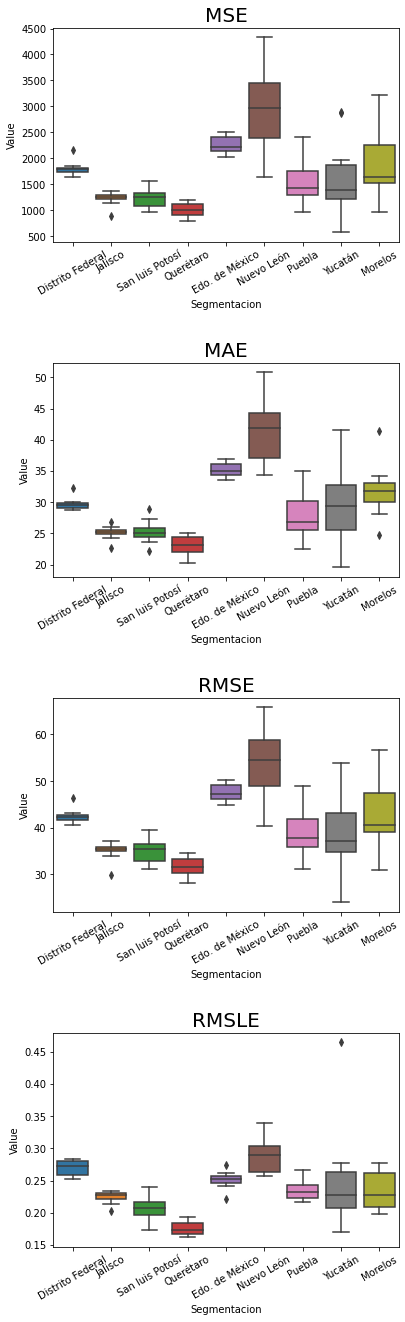

In [40]:
metricas = ['MSE', 'MAE', 'RMSE', 'RMSLE']
dfMSE = pd.DataFrame(columns = ['Segmentacion', 'Value'])
dfMAE = pd.DataFrame(columns = ['Segmentacion', 'Value'])
dfRMSE = pd.DataFrame(columns = ['Segmentacion', 'Value'])
dfRMSLE = pd.DataFrame(columns = ['Segmentacion', 'Value'])
allMetrics = pd.DataFrame(columns = metricas+['Segmentacion'])

for segmentacion, dataframe in dfsProv.items():
    kf = KFold(n_splits = 10)
    segMetrics = pd.DataFrame(columns = metricas+['Segmentacion'])

    for trainidx, testidx in kf.split(dataframe):
        features = modelosProv[segmentacion]        
        train = dataframe[:trainidx[-1]]
        test = dataframe[testidx[0]:testidx[-1]]
        
        newMetricas = linearRegressionTest(train, test, features, ['metroscubiertos'])
        dfMSE = dfMSE.append({'Value': newMetricas['MSE'], 'Segmentacion': segmentacion} ,ignore_index = True)
        dfMAE = dfMAE.append({'Value': newMetricas['MAE'], 'Segmentacion': segmentacion} ,ignore_index = True)
        dfRMSE = dfRMSE.append({'Value': newMetricas['RMSE'], 'Segmentacion': segmentacion} ,ignore_index = True)
        dfRMSLE = dfRMSLE.append({'Value': newMetricas['RMSLE'], 'Segmentacion': segmentacion} ,ignore_index = True)
        
        newMetricas['Segmentacion'] = segmentacion
        segMetrics = segMetrics.append(newMetricas, ignore_index = True)
        segMetrics = segMetrics.groupby(['Segmentacion']).mean().reset_index()

    allMetrics = pd.concat([allMetrics, segMetrics])
        
print(allMetrics.to_latex(index=False))

fig, axs = plt.subplots(nrows = 4, figsize = (8,20))
fig.tight_layout(pad = 10.0)

bplot1 = sns.boxplot(data = dfMSE, x='Segmentacion', y='Value', ax = axs[0])
bplot1.set_title("MSE", size = 20)
bplot1.set_xticklabels(bplot1.get_xticklabels(), rotation=30)

bplot2 = sns.boxplot(data = dfMAE, x='Segmentacion', y='Value', ax = axs[1])
bplot2.set_xticklabels(bplot1.get_xticklabels(), rotation=30)
bplot2.set_title("MAE", size = 20)

bplot3 = sns.boxplot(data = dfRMSE, x='Segmentacion', y='Value', ax = axs[2])
bplot3.set_xticklabels(bplot1.get_xticklabels(), rotation=30)
bplot3.set_title("RMSE", size = 20)

bplot4 = sns.boxplot(data = dfRMSLE, x='Segmentacion', y='Value', ax = axs[3])
bplot4.set_xticklabels(bplot1.get_xticklabels(), rotation=30)
bplot4.set_title("RMSLE", size = 20)

\begin{tabular}{rrrrl}
\toprule
         MSE &        MAE &       RMSE &     RMSLE &          Segmentacion \\
\midrule
 1025.967944 &  20.899327 &  31.494330 &  0.213822 &         Benito Juárez \\
 1084.087109 &  23.218652 &  32.886595 &  0.216619 &               Zapopan \\
 3557.810086 &  40.911694 &  59.222636 &  0.278701 &              Coyoacán \\
 1335.610268 &  27.084840 &  36.422160 &  0.220737 &       San Luis Potosí \\
 1029.574119 &  23.319275 &  31.982231 &  0.182444 &             Querétaro \\
 2655.089920 &  40.022132 &  51.514914 &  0.253043 &   Naucalpan de Juárez \\
 2835.881718 &  40.104763 &  53.127221 &  0.273621 &             Monterrey \\
 1470.339561 &  26.625780 &  37.629411 &  0.237708 &                Puebla \\
  640.885431 &  12.043944 &  23.863567 &  0.156989 &        Miguel Hidalgo \\
 1240.897737 &  27.529650 &  35.085372 &  0.225832 &                Mérida \\
 2024.534341 &  31.586192 &  44.864873 &  0.197352 &          Huixquilucan \\
 2034.778440 &  33.2468

Text(0.5, 1.0, 'RMSLE')

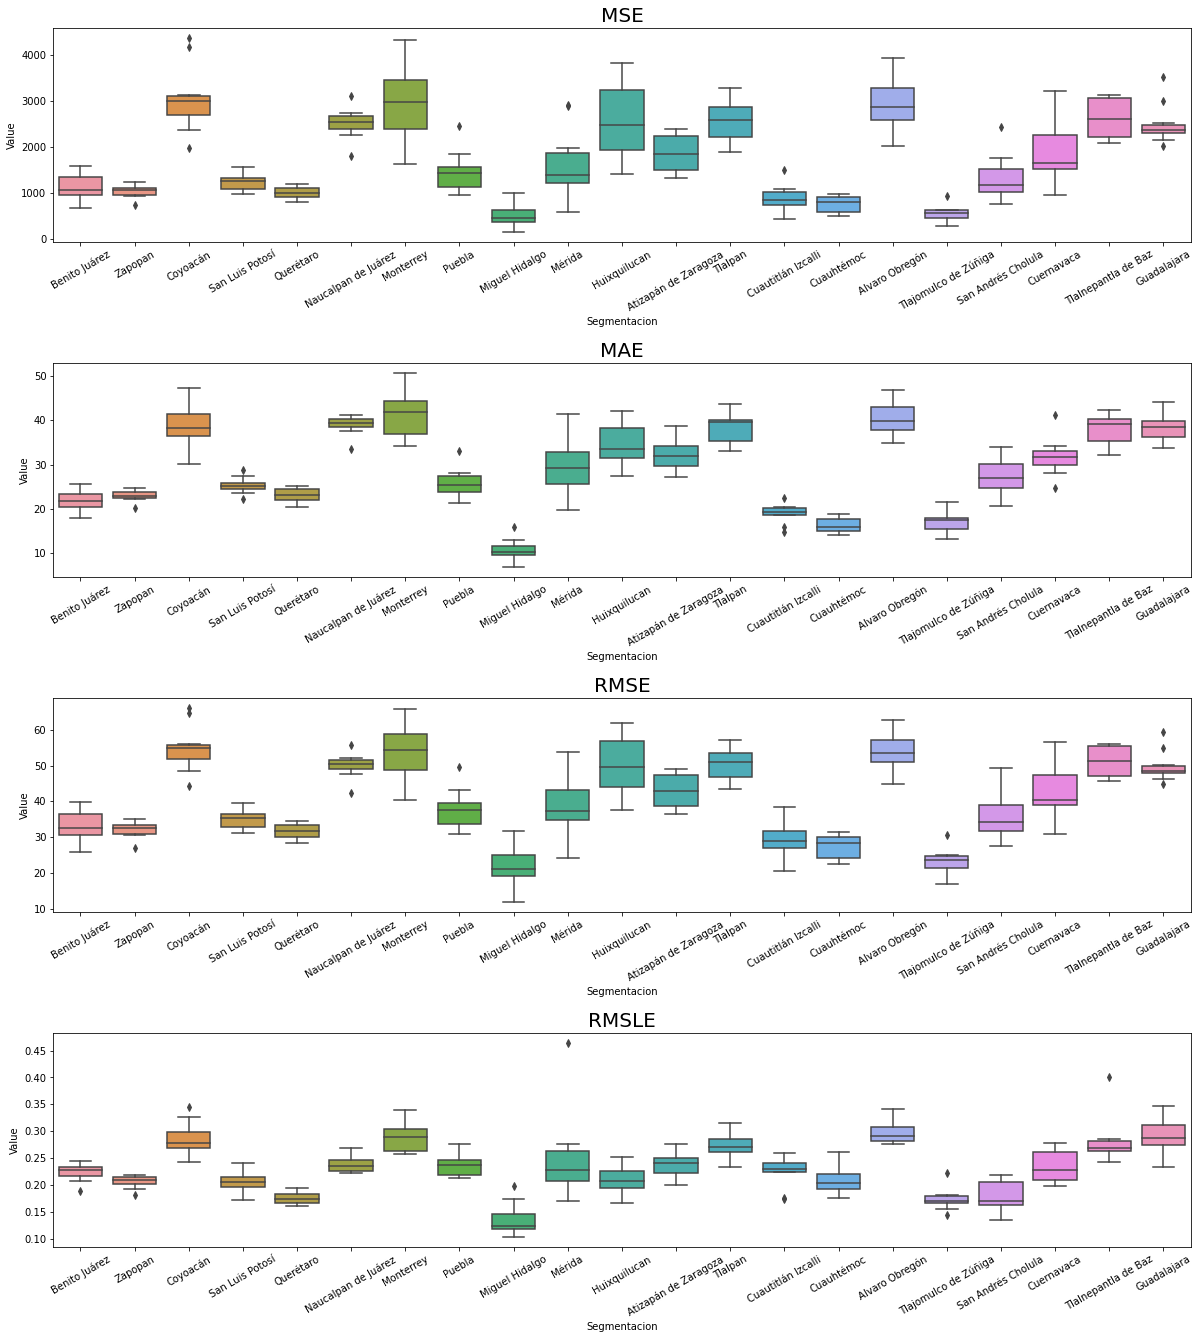

In [43]:
metricas = ['MSE', 'MAE', 'RMSE', 'RMSLE']
dfMSE = pd.DataFrame(columns = ['Segmentacion', 'Value'])
dfMAE = pd.DataFrame(columns = ['Segmentacion', 'Value'])
dfRMSE = pd.DataFrame(columns = ['Segmentacion', 'Value'])
dfRMSLE = pd.DataFrame(columns = ['Segmentacion', 'Value'])
allMetrics = pd.DataFrame(columns = metricas+['Segmentacion'])

for segmentacion, dataframe in dfsCiudad.items():
    kf = KFold(n_splits = 10)
    segMetrics = pd.DataFrame(columns = metricas+['Segmentacion'])

    for trainidx, testidx in kf.split(dataframe):
        features = modelosCiudad[segmentacion]        
        train = dataframe[:trainidx[-1]]
        test = dataframe[testidx[0]:testidx[-1]]
        
        newMetricas = linearRegressionTest(train, test, features, ['metroscubiertos'])
        dfMSE = dfMSE.append({'Value': newMetricas['MSE'], 'Segmentacion': segmentacion} ,ignore_index = True)
        dfMAE = dfMAE.append({'Value': newMetricas['MAE'], 'Segmentacion': segmentacion} ,ignore_index = True)
        dfRMSE = dfRMSE.append({'Value': newMetricas['RMSE'], 'Segmentacion': segmentacion} ,ignore_index = True)
        dfRMSLE = dfRMSLE.append({'Value': newMetricas['RMSLE'], 'Segmentacion': segmentacion} ,ignore_index = True)
        
        newMetricas['Segmentacion'] = segmentacion
        segMetrics = segMetrics.append(newMetricas, ignore_index = True)
        segMetrics = segMetrics.groupby(['Segmentacion']).mean().reset_index()

    allMetrics = pd.concat([allMetrics, segMetrics])
    
print(allMetrics.to_latex(index=False))

fig, axs = plt.subplots(nrows = 4, figsize = (19,20))
fig.tight_layout(pad = 10.0)

bplot1 = sns.boxplot(data = dfMSE, x='Segmentacion', y='Value', ax = axs[0])
bplot1.set_title("MSE", size = 20)
bplot1.set_xticklabels(bplot1.get_xticklabels(), rotation=30)

bplot2 = sns.boxplot(data = dfMAE, x='Segmentacion', y='Value', ax = axs[1])
bplot2.set_xticklabels(bplot1.get_xticklabels(), rotation=30)
bplot2.set_title("MAE", size = 20)

bplot3 = sns.boxplot(data = dfRMSE, x='Segmentacion', y='Value', ax = axs[2])
bplot3.set_xticklabels(bplot1.get_xticklabels(), rotation=30)
bplot3.set_title("RMSE", size = 20)

bplot4 = sns.boxplot(data = dfRMSLE, x='Segmentacion', y='Value', ax = axs[3])
bplot4.set_xticklabels(bplot1.get_xticklabels(), rotation=30)
bplot4.set_title("RMSLE", size = 20)
